# Land Cover Classification with UNet + VGG16

## Packages and functions

In [68]:
# Modules
import numpy as np
from matplotlib import pyplot
from skimage import color, data, exposure, feature, filters, io, morphology, segmentation, transform, util
from image_utilities import *
import tensorflow as tf

import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import PIL
import os
from PIL import Image
import numpy as np
import sklearn
import keras
from PIL import Image
from numpy import asarray
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import random 
from keras.layers import LeakyReLU, concatenate, Dropout,BatchNormalization,Activation

In [69]:
import os
term_project_dir="/Users/pazma/Documents/BSE/spatial_data/term_project/"
os.chdir(term_project_dir)

In [70]:
# import custom-made functions
from helper_functions import *
from preprocess_and_stats import *

## Load the data

In [71]:
# get mask and sat paths from the train folder 
mask_train_files = sorted([f for f in os.listdir(term_project_dir + "data/land-train/") if re.match(r'.*mask\.png', f)])
sat_train_files = sorted([f for f in os.listdir(term_project_dir + "data/land-train/") if re.match(r'.*sat\.jpg', f)])
print(mask_train_files[:10])
print(sat_train_files[:10])

['100694_mask.png', '102122_mask.png', '10233_mask.png', '103665_mask.png', '103730_mask.png', '104113_mask.png', '10452_mask.png', '10901_mask.png', '111335_mask.png', '114433_mask.png']
['100694_sat.jpg', '102122_sat.jpg', '10233_sat.jpg', '103665_sat.jpg', '103730_sat.jpg', '104113_sat.jpg', '10452_sat.jpg', '10901_sat.jpg', '111335_sat.jpg', '114433_sat.jpg']


In [72]:
metadata_train=pd.DataFrame(mask_train_files,sat_train_files).reset_index()
metadata_train.columns=["sat", "mask"]

In [73]:
# class label dictionary
class_dict={"urban_land": [0, 255, 255],
           "agriculture_land": [255, 255, 0],
           "range_land": [255, 0, 255],
           "forest_land": [0, 255, 0],
           "water": [0, 0, 255],
           "barren_land": [255, 255, 255],
           "unknown": [0,0,0]}
class_dict.keys(), class_dict.values()

(dict_keys(['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']),
 dict_values([[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]))

In [74]:
# Get class names
class_names = list(class_dict.keys())
# Get class RGB values
class_rgb_values = list(class_dict.values())

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)


All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [75]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'range_land', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


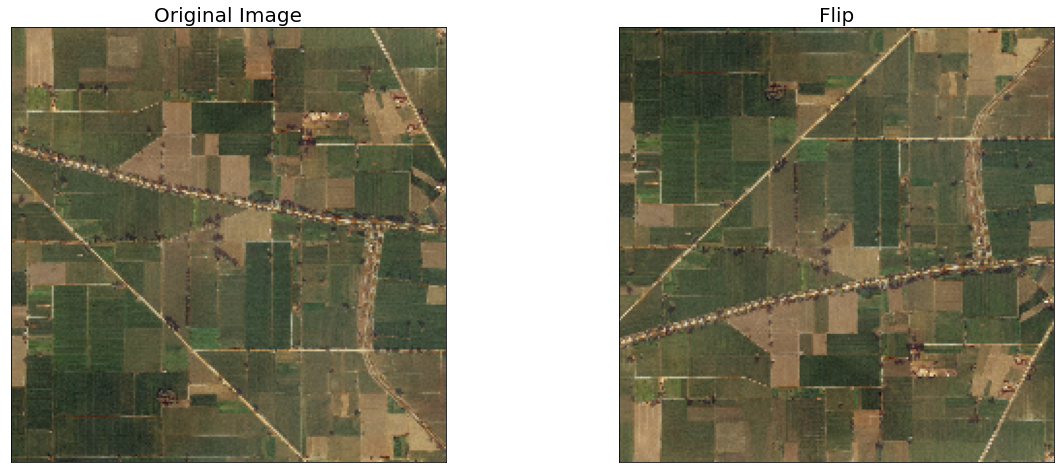

In [76]:
# show augmentation in action
im = load_img(term_project_dir + "data/land-train/"+'10233_sat.jpg',target_size=(224,224,3))
mask = load_img(term_project_dir + "data/land-train/"+'10233_mask.png',target_size=(224,224,3))


a,b = random_vertical_flip(im,mask, prob=1)
visualize(original_image = im, flip = a
         )

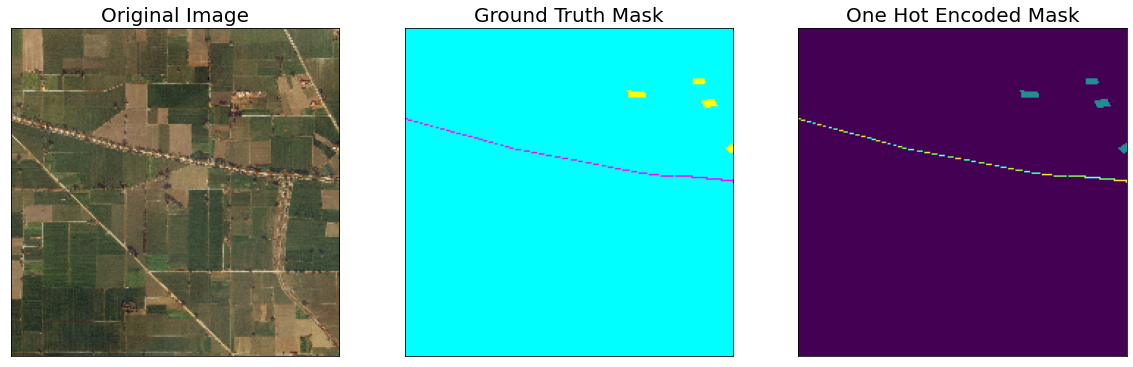

In [77]:
# show a random image with the ground truth and the one-hot encoded mask
BATCH_SIZE=32
dataset = land_cover_DataGenerator(term_project_dir + "data/land-train/", 
                                   class_rgb_values= select_class_rgb_values, batch_size= BATCH_SIZE)
random_idx = random.randint(0, len(dataset)-1)


visualize(
    original_image = im,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

## Build the model

In [35]:
#% INITIALISE UNET + VGG16
def conv_block(inputs,num_filters):
    x = Conv2D(num_filters,3,padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  
    x = Conv2D(num_filters,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  
    return x


def define_decoder(inputs,skip_layer,num_filters):
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    x = Conv2DTranspose(num_filters,(2,2),strides=(2,2),padding='same',kernel_initializer=init)(inputs)  
    g = Concatenate()([x,skip_layer])
    g = conv_block(g,num_filters)
    return g



def vgg16_unet(input_shape, weights_="imagenet"):
    inputs = Input(shape=input_shape) 
    if weights_=="imagenet":
        vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=inputs)  # We will extract encoder layers based on their output shape from vgg16 model  
    elif weights_==path_to_weights:
        vgg16 = VGG16(include_top=False,weights=path_to_weights,input_tensor=inputs)  
        
    s1 = vgg16.get_layer('block1_conv2').output  
    s2 = vgg16.get_layer('block2_conv2').output  
    s3 = vgg16.get_layer('block3_conv3').output  
    s4 = vgg16.get_layer('block4_conv3').output    # bottleneck/bridege layer from vgg16
    b1 = vgg16.get_layer('block5_conv3').output #32

    # Decoder Block
    d1 = define_decoder(b1,s4,512)
    d2 = define_decoder(d1,s3,256)
    d3 = define_decoder(d2,s2,128)
    d4 = define_decoder(d3,s1,64)  #output layer
    outputs = Conv2D(1,1,padding='same',activation='sigmoid')(d4)
    model = Model(inputs,outputs)

    return model

In [36]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

vgg16 = VGG16(include_top=False,weights='imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [37]:
path_to_weights="/Users/pazma/Documents/BSE/spatial_data/term_project/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
LEARNING_RATE = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model = vgg16_unet((224,224,3), path_to_weights)
model.compile(loss="binary_focal_crossentropy",optimizer=opt,metrics=[iou])

In [38]:
BATCH_SIZE = 32 
PATH_TRAIN =term_project_dir+'/data/land-train/'
PATH_VALIDATION = term_project_dir+'/data/land_valid_sat/'
LEARNING_RATE = 0.001
EPOCHS = 20
INPUT_SIZE = (224, 224, 3)
CLASS = select_class_rgb_values

train_generator = land_cover_DataGenerator(PATH_TRAIN,BATCH_SIZE,INPUT_SIZE, 
                                           class_rgb_values=CLASS, augmentation=True, augmentation_prob=0.1)
validation_generator = land_cover_DataGenerator(PATH_VALIDATION,BATCH_SIZE,INPUT_SIZE, class_rgb_values=CLASS, 
                                                augmentation=True, augmentation_prob=0.1)

In [39]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
callbacks = [
  keras.callbacks.EarlyStopping(monitor="acc", patience=10, restore_best_weights=True),
  keras.callbacks.ModelCheckpoint('model_vgg16_unet.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)
]
  

In [ ]:
# fit
vgg16_history = model.fit(train_generator, 
    validation_data =validation_generator,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    verbose=1,
    callbacks=callbacks)

Epoch 1/20


2022-04-01 13:33:19.114370: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-01 13:33:20.065701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/25 [===>..........................] - ETA: 3:57 - loss: 0.1707 - iou: 0.4080

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x3411ba290>
    label = <none> 
    device = <AGXG13GDevice: 0x1693a9400>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x12482b200>
        label = <none> 
        device = <AGXG13GDevice: 0x1693a9400>
            name = Apple M1 
    retainedReferences = 1


25/25 [==============================] - ETA: 0s - loss: 0.1214 - iou: 0.3296 

2022-04-01 13:38:47.121798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: loss improved from inf to 0.12137, saving model to model_vgg16_unet.h5
25/25 [==============================] - 338s 13s/step - loss: 0.1214 - iou: 0.3296 - val_loss: 0.4248 - val_iou: 9.8678e-22
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 0.1102 - iou: 0.3391 WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,iou,val_loss,val_iou

Epoch 2: loss improved from 0.12137 to 0.11019, saving model to model_vgg16_unet.h5
25/25 [==============================] - 314s 12s/step - loss: 0.1102 - iou: 0.3391 - val_loss: 0.2345 - val_iou: 1.1475e-21
Epoch 3/20
19/25 [=====================>........] - ETA: 1:11 - loss: 0.1093 - iou: 0.3377

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x28eaf97d0>
    label = <none> 
    device = <AGXG13GDevice: 0x1693a9400>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x12482b200>
        label = <none> 
        device = <AGXG13GDevice: 0x1693a9400>
            name = Apple M1 
    retainedReferences = 1


25/25 [==============================] - ETA: 0s - loss: 0.1093 - iou: 0.3381 WARNING:tensorflow:Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,iou,val_loss,val_iou

Epoch 3: loss improved from 0.11019 to 0.10925, saving model to model_vgg16_unet.h5
25/25 [==============================] - 321s 13s/step - loss: 0.1093 - iou: 0.3381 - val_loss: 0.1773 - val_iou: 1.2445e-21
Epoch 4/20
 4/25 [===>..........................] - ETA: 3:58 - loss: 0.1090 - iou: 0.3383

In [ ]:
# Displays history
display_history(vgg16_history)

# Saves model and history
keras.models.save_model(model, 'unet_vgg16.h5')
np.save('model/history_baseline_vgg16.npy', training.history)

In [40]:
# load model
vgg16_model=keras.models.load_model("model_vgg16_unet.h5", compile=False)

In [41]:
vgg16_model.compile(loss="binary_focal_crossentropy",optimizer=opt,metrics=[iou])

## Evaluate

In [42]:
score=vgg16_model.evaluate(validation_generator, verbose=0)
print("val loss:", score[0])
print("val accuracy:", score[1])

2022-04-01 16:20:41.280961: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-01 16:20:41.587658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


val loss: 0.1773492395877838
val accuracy: 1.2444866682632987e-21


In [47]:
PATH_TEST=term_project_dir+'/data/land_test_sat/'
test_generator = land_cover_DataGenerator(PATH_TEST,BATCH_SIZE,INPUT_SIZE, class_rgb_values=CLASS, 
                                                augmentation=False)

In [96]:
import glob
test_images=glob.glob(term_project_dir+'/data/land_test_sat/*')

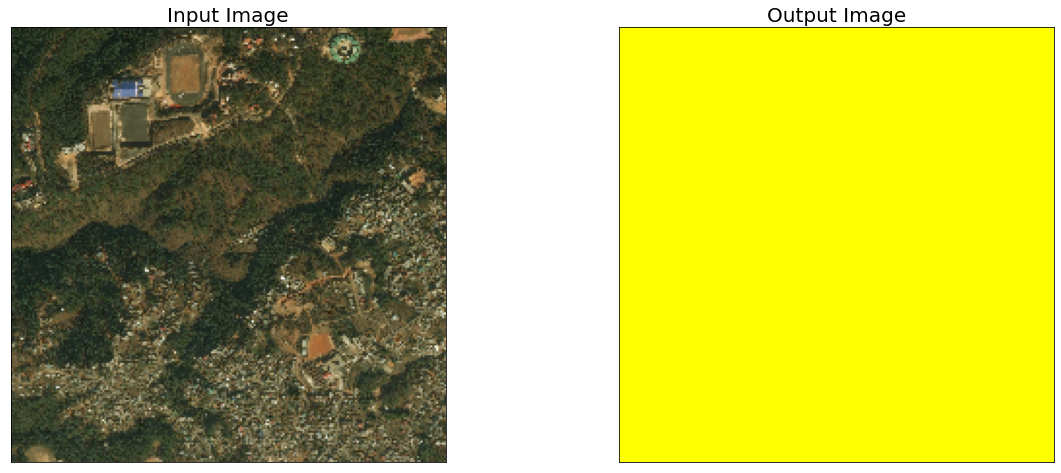

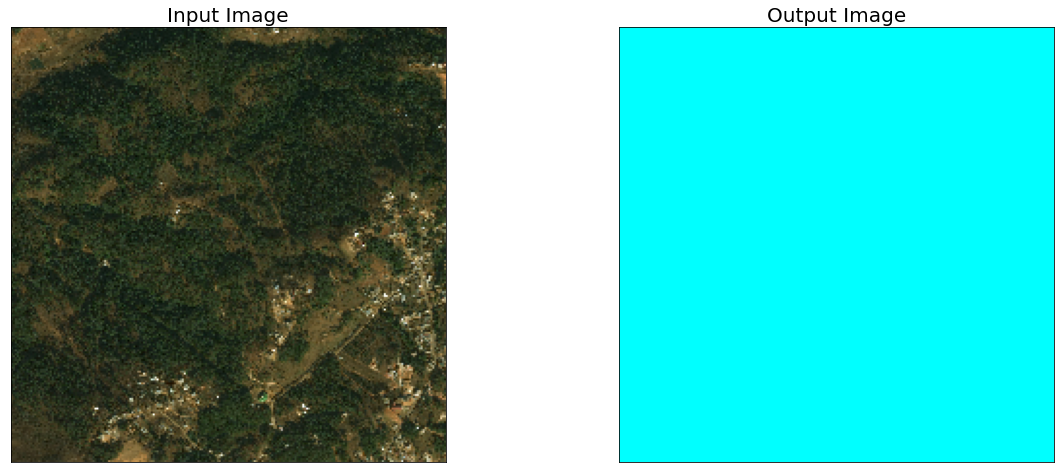

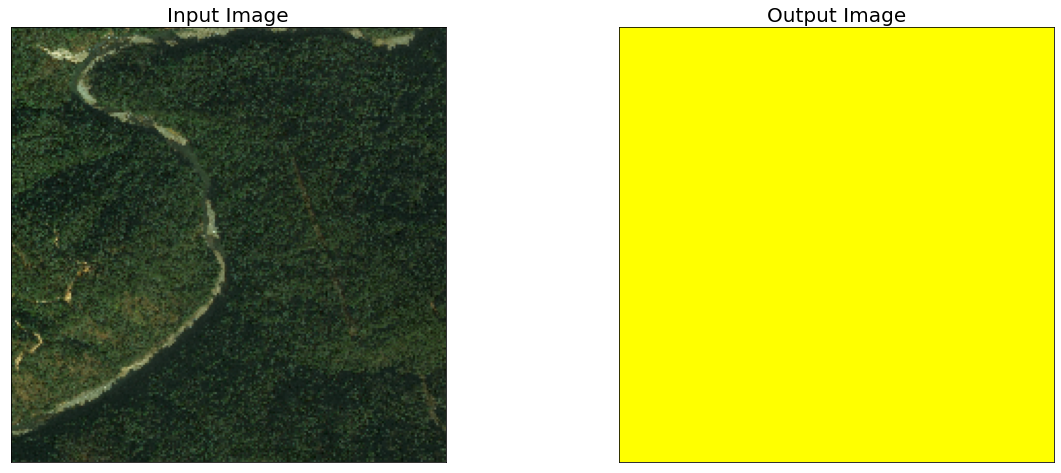

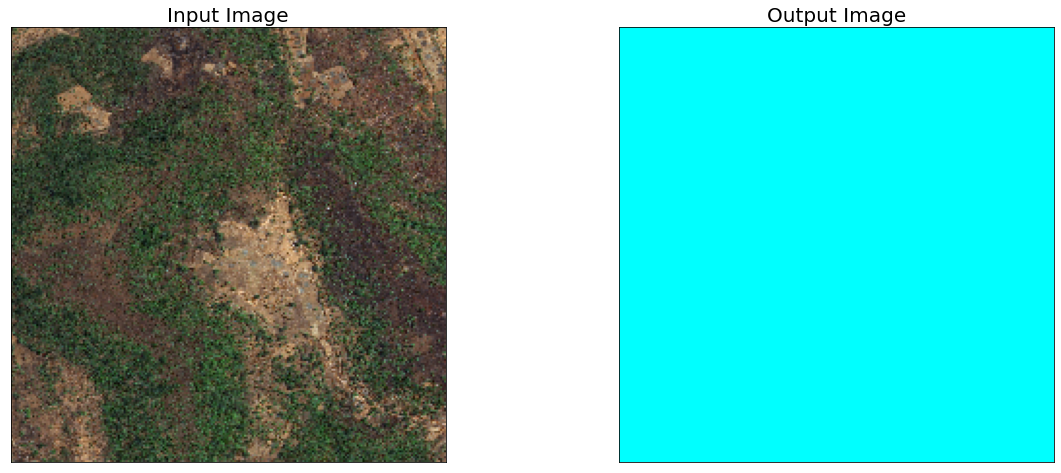

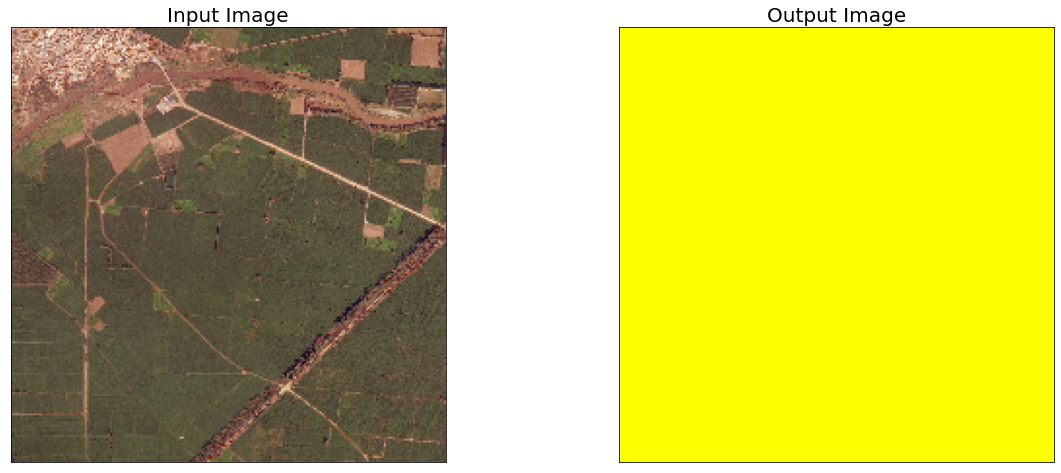

In [98]:
# load test images and their predictions
for i in np.random.choice(range(len(test_images)), 5, replace=False):
    im = load_img(test_images[i],target_size=(224,224,3))
    # predict
    im=np.expand_dims(im, axis=0)
    output=colour_code_segmentation(reverse_one_hot(output), select_class_rgb_values)

    # visualize prediction
    visualize(
        input_image=np.squeeze(im),
        output_image=np.squeeze(output) #,
        # gt_image=mask     
            )